*Import libraries*

In [0]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)

In [0]:
#Path definitions
PLATES = './plateImages/'

*Read image in grayscale*

(24, 130)


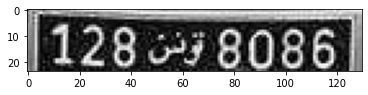

In [0]:
im = cv2.imread(PLATES+"1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap=plt.cm.gray)
print(im.shape)

*Apply Niblack's local threshhold*

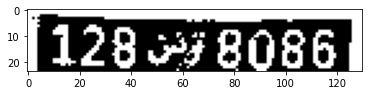

In [0]:
#Local binarization Niblack's
window_size = 25
thresh_niblack = threshold_niblack(im, window_size=window_size, k=0)
binary_niblack = im > thresh_niblack
plt.imshow(binary_niblack, cmap=plt.cm.gray)

First method with global threshhold

In [0]:
(_, gray) = cv2.threshold(im, 170, 255, cv2.THRESH_OTSU)
plt.imshow(gray)

In [0]:
ctrs,_ = cv2.findContours(im.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
j=0
digits = []
for rect in rects:
    x = rect[0]
    y = rect[1]
    w = rect[2]
    h = rect[3]
    crop_im = im[y:y+h, x:x+w]
    #if w > h:
    #    continue
    #if h < 15:
    #    continue
    digits.append(crop_im)
    plt.figure(figsize=(3,3))
    plt.imshow(crop_im)
    plt.show()